# Algorithm Metrics

This notebook shows algorithm metrics over the release branches.

In [1]:
import re
from pathlib import Path
from packaging.version import parse as parse_version
import json

In [2]:
import pandas as pd
import seaborn as sns

## Load DVC metrics

Let's load all the DVC metrics:

In [3]:
run_dir = Path('runs')

In [4]:
metrics = {}
for file in run_dir.glob('*/metrics.csv'):
    ver = file.parent.name
    metrics[ver] = pd.read_csv(file)
list(metrics.keys())

['0.10', '0.11', '0.12', '0.13', '0.14', '0.9', 'main']

In [5]:
versions = [k for k in metrics.keys() if k != 'main']
versions.sort(key=parse_version)
versions.append('main')
versions

['0.9', '0.10', '0.11', '0.12', '0.13', '0.14', 'main']

Now let's collect all these metrics into a frame:

In [6]:
mdf = pd.concat(metrics, names=['version'])
# pull version out of index
mdf.reset_index('version', inplace=True)
# drop remaining index
mdf.reset_index(drop=True, inplace=True)
# set up category and ordering
mdf = mdf.astype({'version': 'category'})
mdf['version'] = mdf['version'].cat.reorder_categories(versions)
mdf

,version,nDCG,GRMSE,TrainTime,train_times,run
0,0.10,0.032576,0.856024,105.461504,"[108.6556128510274, 104.92342124367133, 105.46...",ml20m-ALS
1,0.10,0.001980,0.843864,86.567539,"[93.5135499718599, 75.96282556978986, 75.44681...",ml20m-II
2,0.10,0.180311,NaN,2.515146,"[8.585054113995284, 2.4986445090034977, 2.4966...",ml1m-IALS
3,0.10,0.034272,0.921490,0.188053,"[2.800749860238284, 0.1902934769168496, 0.1880...",ml1m-UU
4,0.10,0.013852,0.846062,32.349516,"[33.03306156536564, 29.005726043134928, 31.439...",ml10m-II
...,...,...,...,...,...,...
105,main,0.038666,0.857261,19.217808,"[19.133778038987657, 19.354344694002066, 19.21...",ml10m-ALS
106,main,0.285588,NaN,21.075710,"[20.785608720994787, 21.01590994000435, 21.075...",ml10m-IALS
107,main,0.001897,0.844404,82.577516,"[82.57751557900338, 82.25773263598967, 83.1387...",ml20m-II
108,main,0.030224,0.856436,40.229840,"[39.94338740600506, 40.58253752600285, 40.2298...",ml20m-ALS


And get data sets & algorithms from run keys:

In [7]:
mdf['data'] = mdf['run'].str.replace(r'^(\w+)-.*', r'\1', regex=True)
mdf['algo'] = mdf['run'].str.replace(r'^\w+-(.*)', r'\1', regex=True)
mdf

,version,nDCG,GRMSE,TrainTime,train_times,run,data,algo
0,0.10,0.032576,0.856024,105.461504,"[108.6556128510274, 104.92342124367133, 105.46...",ml20m-ALS,ml20m,ALS
1,0.10,0.001980,0.843864,86.567539,"[93.5135499718599, 75.96282556978986, 75.44681...",ml20m-II,ml20m,II
2,0.10,0.180311,NaN,2.515146,"[8.585054113995284, 2.4986445090034977, 2.4966...",ml1m-IALS,ml1m,IALS
3,0.10,0.034272,0.921490,0.188053,"[2.800749860238284, 0.1902934769168496, 0.1880...",ml1m-UU,ml1m,UU
4,0.10,0.013852,0.846062,32.349516,"[33.03306156536564, 29.005726043134928, 31.439...",ml10m-II,ml10m,II
...,...,...,...,...,...,...,...,...
105,main,0.038666,0.857261,19.217808,"[19.133778038987657, 19.354344694002066, 19.21...",ml10m-ALS,ml10m,ALS
106,main,0.285588,NaN,21.075710,"[20.785608720994787, 21.01590994000435, 21.075...",ml10m-IALS,ml10m,IALS
107,main,0.001897,0.844404,82.577516,"[82.57751557900338, 82.25773263598967, 83.1387...",ml20m-II,ml20m,II
108,main,0.030224,0.856436,40.229840,"[39.94338740600506, 40.58253752600285, 40.2298...",ml20m-ALS,ml20m,ALS


## ALS Results

Let's first look at biased MF from ALS:

<Axes: xlabel='version', ylabel='GRMSE'>

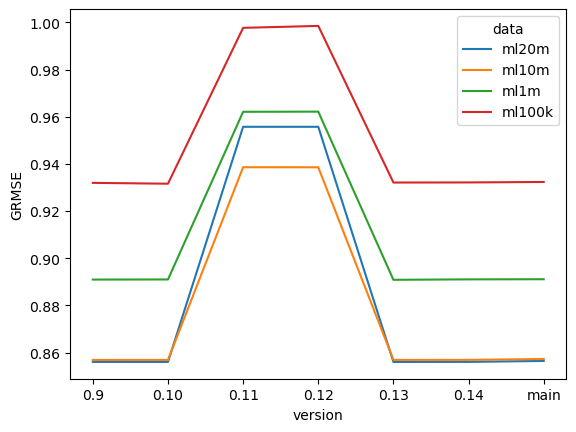

In [8]:
als = mdf[mdf['algo'] == 'ALS']
sns.lineplot(x='version', y='GRMSE', hue='data', data=als)

<Axes: xlabel='version', ylabel='nDCG'>

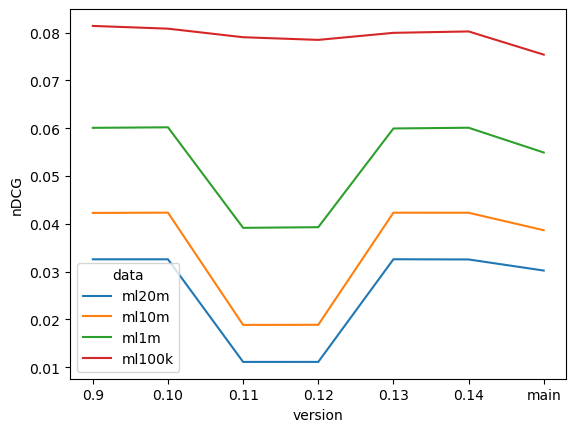

In [9]:
als = mdf[mdf['algo'] == 'ALS']
sns.lineplot(x='version', y='nDCG', hue='data', data=als)

## Item-Item Results

Now the item-item results:

<Axes: xlabel='version', ylabel='GRMSE'>

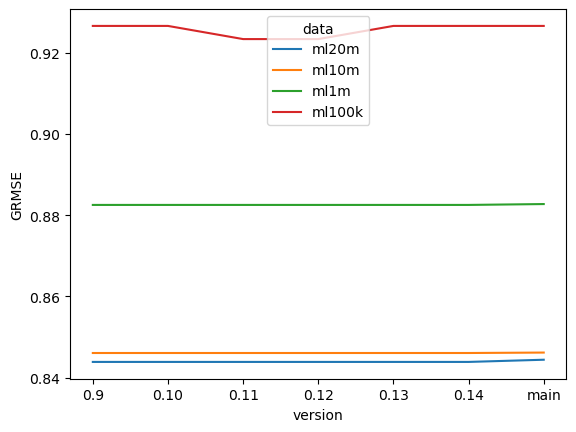

In [10]:
ii_exp = mdf[mdf['algo'] == 'II']
sns.lineplot(x='version', y='GRMSE', hue='data', data=ii_exp)

<Axes: xlabel='version', ylabel='nDCG'>

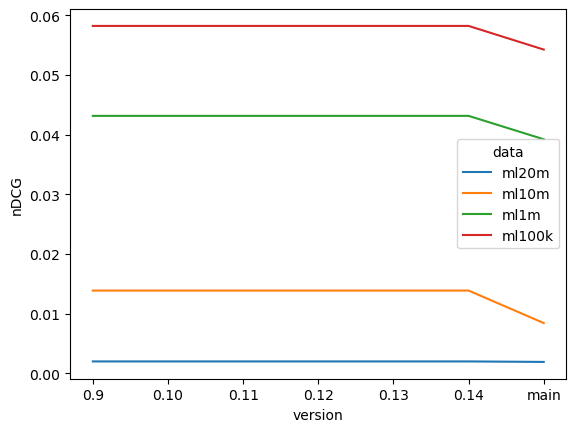

In [11]:
ii_exp = mdf[mdf['algo'] == 'II']
sns.lineplot(x='version', y='nDCG', hue='data', data=ii_exp)

## User-User Results


<Axes: xlabel='version', ylabel='GRMSE'>

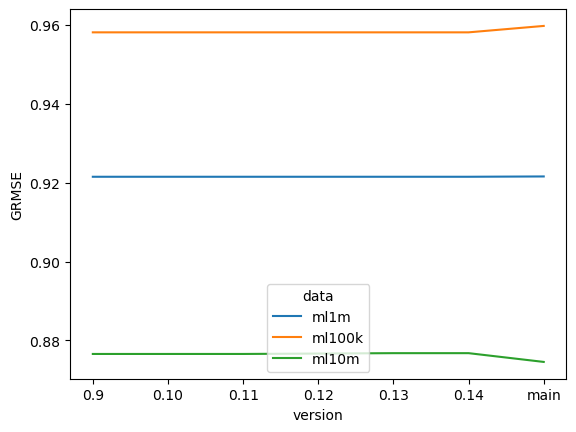

In [12]:
uu_exp = mdf[mdf['algo'] == 'UU']
sns.lineplot(x='version', y='GRMSE', hue='data', data=uu_exp)

<Axes: xlabel='version', ylabel='nDCG'>

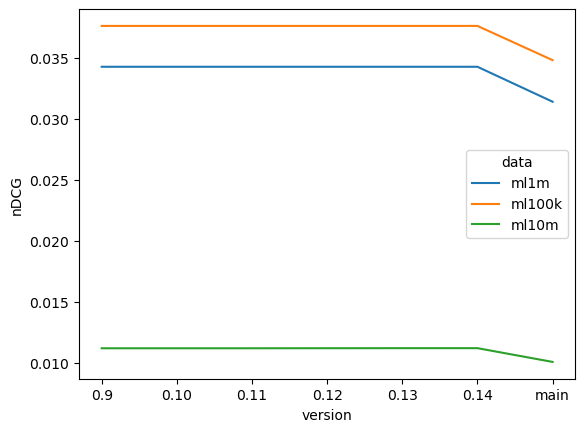

In [13]:
uu_exp = mdf[mdf['algo'] == 'UU']
sns.lineplot(x='version', y='nDCG', hue='data', data=uu_exp)

## IALS Results

Let's first look at biased MF from Implicit ALS:

<Axes: xlabel='version', ylabel='nDCG'>

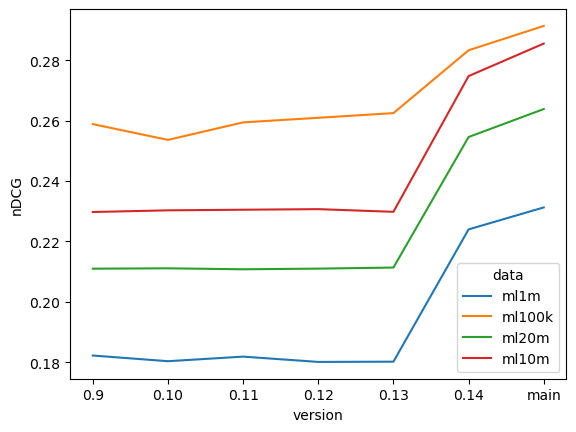

In [14]:
als = mdf[mdf['algo'] == 'IALS']
sns.lineplot(x='version', y='nDCG', hue='data', data=als)

## Implicit BPR Results

We also test BPR implementation from Implicit.

<Axes: xlabel='version', ylabel='nDCG'>

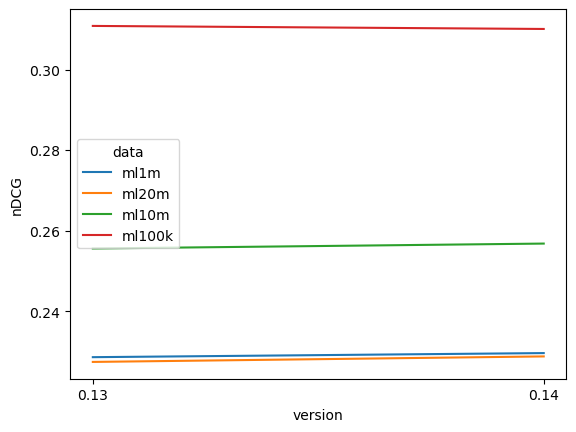

In [15]:
als = mdf[mdf['algo'] == 'impBPR']
sns.lineplot(x='version', y='nDCG', hue='data', data=als)

## Combined Algorithm Results

Let's look at all the algorithms together as a point plot:

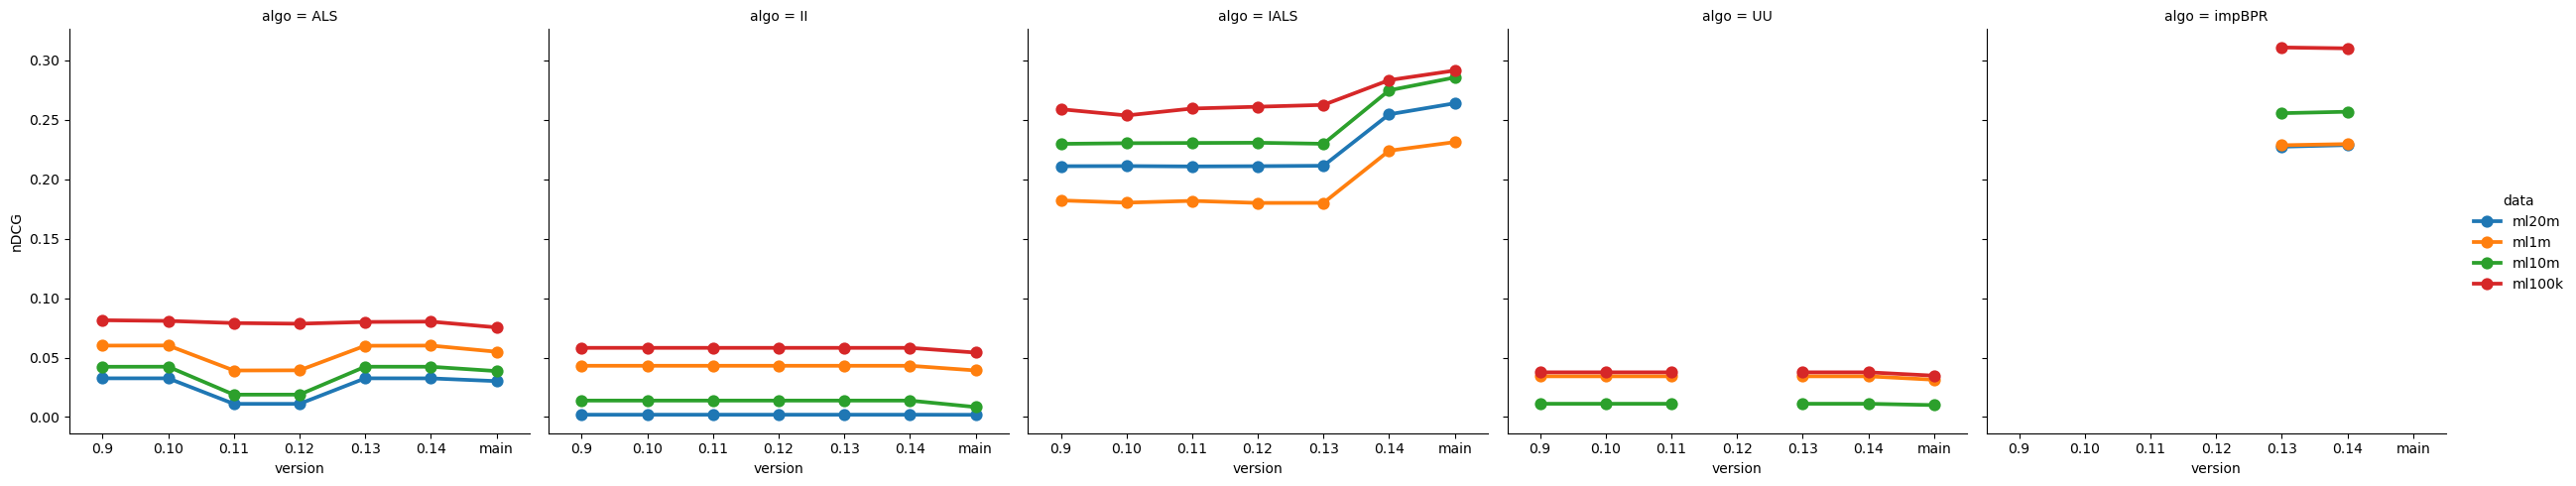

In [16]:
sns.catplot(x='version', y='nDCG', hue='data', col='algo', data=mdf, kind='point')